# Instance-based Counterfactual Explanations for Time Series Classification
Delaney et al.[1] proposed using the K-nearest neighbors from the dataset belonging to a different class as native guide to generate counterfactuals. They propose three options for transforming the original time series with this native guide: the plain native guide, the native guide with bary centering, and transformation based on the native guide and class activation mapping. The desired method can be selected by providing the method parameter during interpretability instantiation.

The code in TSInterpret is based on the authors <a href='https://github.com/e-delaney/Instance-Based_CFE_TSC'>implementation </a>.

[1] E. Delaney, D. Greene, and M. T. Keane. Instance-Based Counterfactual Explanations for Time Series Classification. In A. A. S ́anchez-Ruiz and M. W. Floyd, editors, Case-
Based Reasoning Research and Development, volume 12877, pages 32–47. Springer International Publishing, Cham, 2021. ISBN 978-3-030-86956-4 978-3-030-86957-1. doi:
10.1007/978-3-030-86957-1 3. Series Title: Lecture Notes in Computer Science.

In [1]:
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 
import warnings
warnings.filterwarnings("ignore") 

/home/jacqueline/.local/share/virtualenvs/TSInterpret-x4eqnPOt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

Load Data and reshape the data to fit a 1D-Conv ResNet. Note that the input for a 1D-Conv Resnet hat the shape (batch, features, timesteps).

In [2]:
dataset='ECG5000'

In [3]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])

In [4]:
np.unique(test_y)

array([1, 2, 3, 4, 5])

In [5]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
f= open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb')
pickle.dump(enc1,f)

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

## Model Training / Loading
Trains a ResNet and saves the results.

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


In [7]:
model = ResNetBaseline(in_channels= train_x.shape[-2], num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)
#test_preds=np.argmax(test_preds,axis=1)
sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../../ClassificationModels/models/{dataset}/classification_report.csv', index = False)


Epoch: 1, Train loss: 0.569, Val loss: 0.436
Epoch: 2, Train loss: 0.486, Val loss: 0.296
Epoch: 3, Train loss: 0.305, Val loss: 0.296
Epoch: 4, Train loss: 0.345, Val loss: 0.393
Epoch: 5, Train loss: 0.269, Val loss: 0.273
Epoch: 6, Train loss: 0.342, Val loss: 0.368
Epoch: 7, Train loss: 0.273, Val loss: 0.297
Epoch: 8, Train loss: 0.231, Val loss: 0.292
Epoch: 9, Train loss: 0.214, Val loss: 0.559
Epoch: 10, Train loss: 0.247, Val loss: 0.258
Epoch: 11, Train loss: 0.231, Val loss: 0.25
Epoch: 12, Train loss: 0.201, Val loss: 0.303
Epoch: 13, Train loss: 0.172, Val loss: 0.31
Epoch: 14, Train loss: 0.222, Val loss: 0.28
Epoch: 15, Train loss: 0.185, Val loss: 0.278
Epoch: 16, Train loss: 0.227, Val loss: 0.254
Epoch: 17, Train loss: 0.192, Val loss: 0.227
Epoch: 18, Train loss: 0.156, Val loss: 0.238
Epoch: 19, Train loss: 0.149, Val loss: 0.233
Epoch: 20, Train loss: 0.197, Val loss: 0.299
Epoch: 21, Train loss: 0.225, Val loss: 0.29
Epoch: 22, Train loss: 0.193, Val loss: 0.281
E

## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

### 1. & 2. Loading  & Instantiation
Native Guide counterfactuals works on all models tensorflow and pyTorch models returning a probability function. The Initialization takes the following arguments:


    `model`: The model to be explaines.
    `shape`: The data shape in form of (features, timesteps).
    `data`: Tuple of Data and Labels used to find and build CF.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: Optimization Method either `brut` or `opt`.


In [8]:
item=test_x[10].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [9]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF \
     import NativeGuideCF
exp_model=NativeGuideCF(model,(train_x,train_y), \
    backend='PYT', mode='feat',method="NUN_CF")

2023-08-04 16:53:38.340266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 16:53:39.151477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(1, 140)


### 3. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained.
- `target`: desired target class of CF.

In [10]:
exp,label=exp_model.explain(item, np.argmax(y_target,axis=1) )

### 4. Visualization

Plot function takes as input the item to be explained and the returned explanation, as well as the assigned labels.

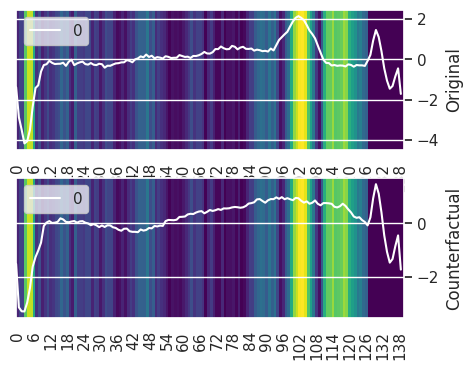

In [11]:

exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

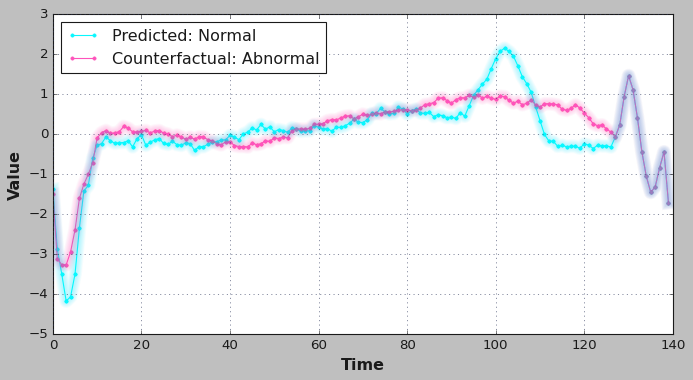

In [12]:
exp_model.plot_in_one(item,'Normal',exp,'Abnormal','NUN_CF')

In [13]:
def plot_in_one(self,item,org_label,exp,cf_label, save_fig= None,figsize=(15,15)):
        """
        Plot Function for Counterfactuals in uni-and multivariate setting. In the multivariate setting only the changed features are visualized.
        Arguments:
            item np.array: original instance.
            org_label int: originally predicted label. 
            exp np.array: returned explanation. 
            cf_label int: lebel of returned instance. 
            figsize Tuple: Size of Figure (x,y).
            save_fig str: Path to Save the figure.
        """
        if self.mode == 'time':
            item = item.reshape(item.shape[0],item.shape[2],item.shape[1]) 
        #TODO This is new and needs to be testes
        if item.shape[-2]>1:
            res = (item != exp).any(-1)
            ind=np.where(res[0])
            if len(ind[0]) == 0:
                print('Items are identical')
                return
            elif len(ind[0]) > 1:
                self.plot_multi(item,org_label,exp,cf_label,figsize=figsize, save_fig=save_fig)
                return
            else: 
                item =item[ind]
        
        plt.style.use("classic")
        colors = [
            '#08F7FE',  # teal/cyan
            '#FE53BB',  # pink
            '#F5D300',  # yellow
            '#00ff41',  # matrix green
        ]
        indices= np.where(exp[0] != item)
        df = pd.DataFrame({f'Predicted: {org_label}': list(item.flatten()),
                   f'Counterfactual: {cf_label}': list(exp.flatten())})
        fig, ax = plt.subplots(figsize=(10,5))
        df.plot(marker='.', color=colors, ax=ax)
        # Redraw the data with low alpha and slighty increased linewidth:
        n_shades = 10
        diff_linewidth = 1.05
        alpha_value = 0.3 / n_shades
        for n in range(1, n_shades+1):
            df.plot(marker='.',
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)

        ax.grid(color='#2A3459')
        plt.xlabel('Time', fontweight = 'bold', fontsize='large')
        plt.ylabel('Value', fontweight = 'bold', fontsize='large')
        if save_fig is None: 
            plt.show()
        else:
            plt.savefig(save_fig)


Additional Examples, e.g. for the use with LSTM or TF can be found <a href='https://github.com/JHoelli/TSInterpret/blob/main/docs/Notebooks'>here</a>.